## Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import numpy as np
import matplotlib.pyplot as plt

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


### Load Single-Agent activations

In [2]:
import os
import sys

path = os.getcwd() + "/datasets/rnn_grid_cells"
sys.path.append(path)
from neurometry.datasets.load_rnn_grid_cells import load_activations

In [3]:
os.getcwd()

'/home/facosta/neurometry/neurometry'

In [4]:
# parent_dir = "/scratch/facosta/rnn_grid_cells"
parent_dir = path
single_model_folder = "Single agent path integration high res/Seed 0"
single_model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06"
single_file_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters
)


epochs = ["final"]

(
    single_agent_activations,
    single_agent_rate_maps,
    single_agent_state_points,
    single_agent_positions,
    single_agent_gs,
) = load_activations(epochs, single_file_path, version="single", verbose=True)

Epoch final found.
Loaded epochs ['final'] of single agent model.
activations has shape (4096, 20, 20, 5). There are 4096 grid cells with 20 x 20 environment resolution, averaged over 5 trajectories.
state_points has shape (4096, 2000). There are 2000 data points in the 4096-dimensional state space.
rate_maps has shape (4096, 400). There are 400 data points averaged over 5 trajectories in the 4096-dimensional state space.
positions has shape (100000, 2).


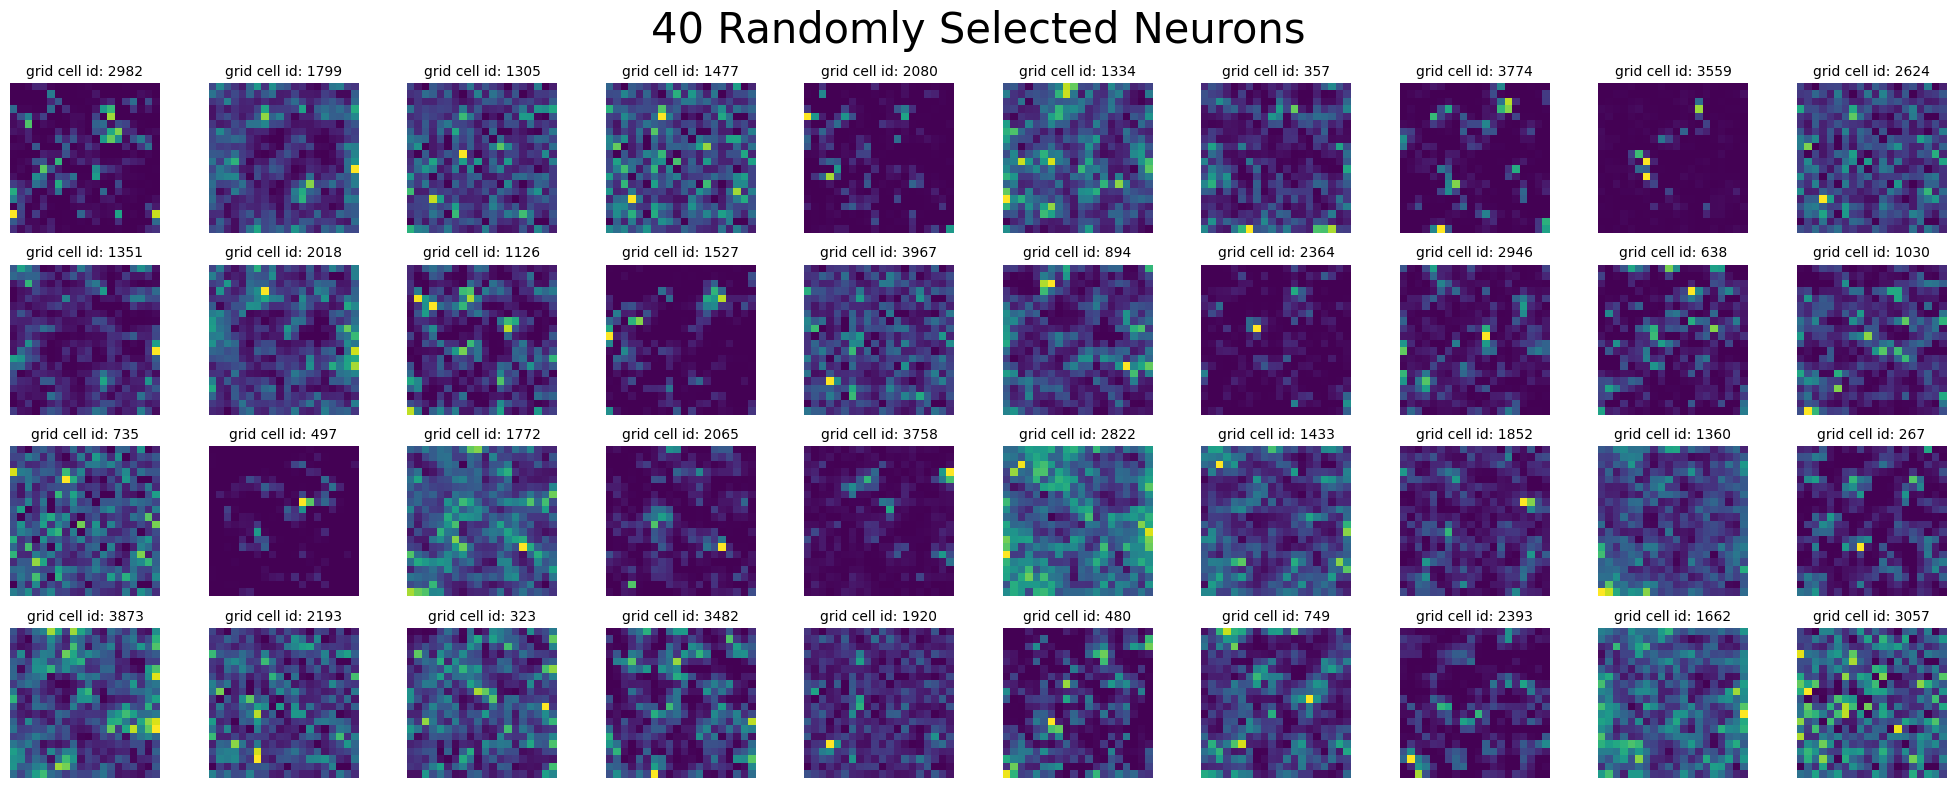

In [5]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map


num_plots = 40
plot_rate_map(
    None,
    num_plots,
    single_agent_activations[-1],
    title=f"{num_plots} Randomly Selected Neurons",
)

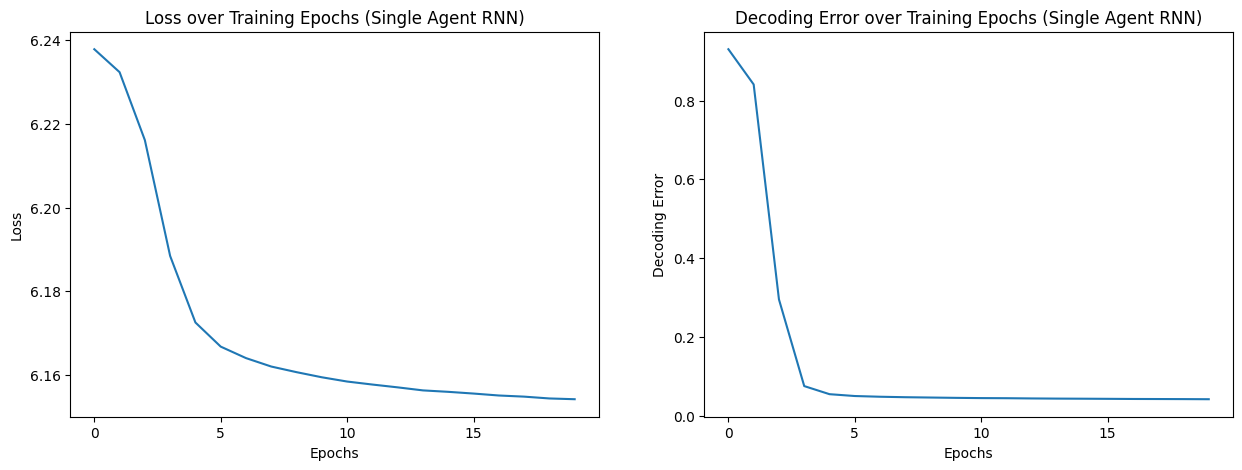

In [6]:
loss_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters, "loss.npy"
)
loss = np.load(loss_path)
loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)

decoding_error_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters, "decoding_error.npy"
)

decoding_error = np.load(decoding_error_path)
decoding_error_aggregated = np.mean(decoding_error.reshape(-1, 1000), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs = list(range(0, 20))
axs[0].plot(epochs, loss_aggregated)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Training Epochs (Single Agent RNN)")

axs[0].set_xticks(epochs[::5])

axs[1].plot(epochs, decoding_error_aggregated)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Decoding Error")
axs[1].set_title("Decoding Error over Training Epochs (Single Agent RNN)")

axs[1].set_xticks(epochs[::5]);

In [7]:
representations = []

for rep in single_agent_rate_maps:
    points = rep.T
    norm_points = points / np.linalg.norm(points, axis=1)[:, None]
    representations.append(norm_points)

In [8]:
representations[0].shape

(400, 4096)

## UMAP + DBSCAN on spatial autocorrelations

In [9]:
from tqdm import tqdm
from neurometry.datasets.rnn_grid_cells.scores import GridScorer


def compute_spatial_autocorrelation(res, rate_map_single_agent, scorer):
    print("Computing spatial auto-correlation...")
    _, _, _, _, spatial_autocorrelation, _ = zip(
        *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_single_agent)]
    )

    spatial_autocorrelation = np.array(spatial_autocorrelation)

    return spatial_autocorrelation


starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)

box_width = 2.2
box_height = 2.2

res = 20

coord_range = ((-box_width / 2, box_width / 2), (-box_height / 2, box_height / 2))

masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)


spatial_autocorrelation = compute_spatial_autocorrelation(
    res, single_agent_rate_maps[-1], scorer
)

print(spatial_autocorrelation.shape)


def z_standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)


def vectorized_spatial_autocorrelation_matrix(spatial_autocorrelation):
    num_cells = spatial_autocorrelation.shape[0]
    num_bins = spatial_autocorrelation.shape[1] * spatial_autocorrelation.shape[2]

    spatial_autocorrelation_matrix = np.zeros((num_bins, num_cells))

    for i in range(num_cells):
        vector = spatial_autocorrelation[i].flatten()

        spatial_autocorrelation_matrix[:, i] = vector

    return z_standardize(spatial_autocorrelation_matrix)

Computing spatial auto-correlation...


100%|██████████| 4096/4096 [00:26<00:00, 155.06it/s]

(4096, 39, 39)


In [12]:
spatial_autocorrelation_matrix = vectorized_spatial_autocorrelation_matrix(
    spatial_autocorrelation
)

print(spatial_autocorrelation_matrix.shape)

(1521, 4096)


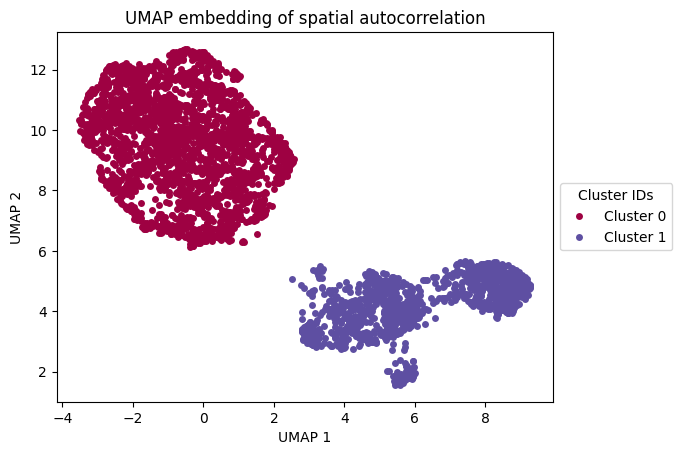

In [13]:
from sklearn.cluster import DBSCAN
import umap

umap_reducer_2d = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer_2d.fit_transform(spatial_autocorrelation_matrix.T)

# Clustering with DBSCAN
umap_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(umap_embedding)

# Plot each cluster
unique_labels = np.unique(umap_dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = umap_dbscan.labels_ == k

    xy = umap_embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="none",
        markersize=5,
        label=f"Cluster {k}",
    )  # Removed black edge

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP embedding of spatial autocorrelation")
plt.legend(
    title="Cluster IDs", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Moved legend to the right
plt.show()

In [14]:
single_agent_rate_maps[-1].shape

(4096, 400)

In [15]:
umap_clusters = umap_dbscan.fit_predict(umap_embedding)


def get_data_from_cluster(data, cluster_id):
    return data[umap_clusters == cluster_id]


clusters = []

for i in np.unique(umap_clusters):
    cluster = get_data_from_cluster(single_agent_rate_maps[-1], i)
    clusters.append(cluster)

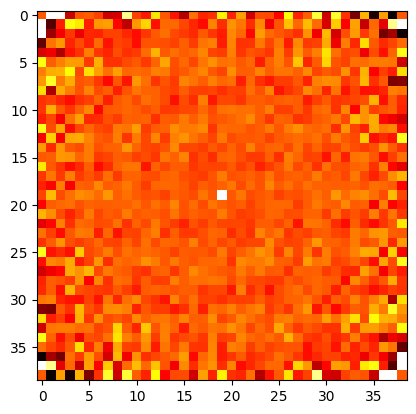

In [21]:
plt.imshow(spatial_autocorrelation[1000], cmap="hot", interpolation="nearest");

In [17]:
clusters[0].shape

(2658, 400)

### Compute Persistent Homology using $\texttt{giotto-tda}$

## Load Dual-Agent activations

In [8]:
parent_dir = "/scratch/facosta/rnn_grid_cells"
dual_model_folder = "Dual agent path integration high res/Seed 0"
dual_model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06"
dual_file_path = os.path.join(parent_dir, dual_model_folder, dual_model_parameters)


epochs = ["final"]

(
    dual_agent_activations,
    dual_model_folder_agent_rate_maps,
    dual_agent_state_points,
    dual_agent_positions,
    dual_agent_gs,
) = load_activations(epochs, dual_file_path, version="dual", verbose=True)

Epoch final found.
Loaded epochs ['final'] of dual agent model.
activations has shape (4096, 20, 20, 5). There are 4096 grid cells with 20 x 20 environment resolution, averaged over 5 trajectories.
state_points has shape (4096, 2000). There are 2000 data points in the 4096-dimensional state space.
rate_maps has shape (4096, 400). There are 400 data points averaged over 5 trajectories in the 4096-dimensional state space.
positions has shape (100000, 2).


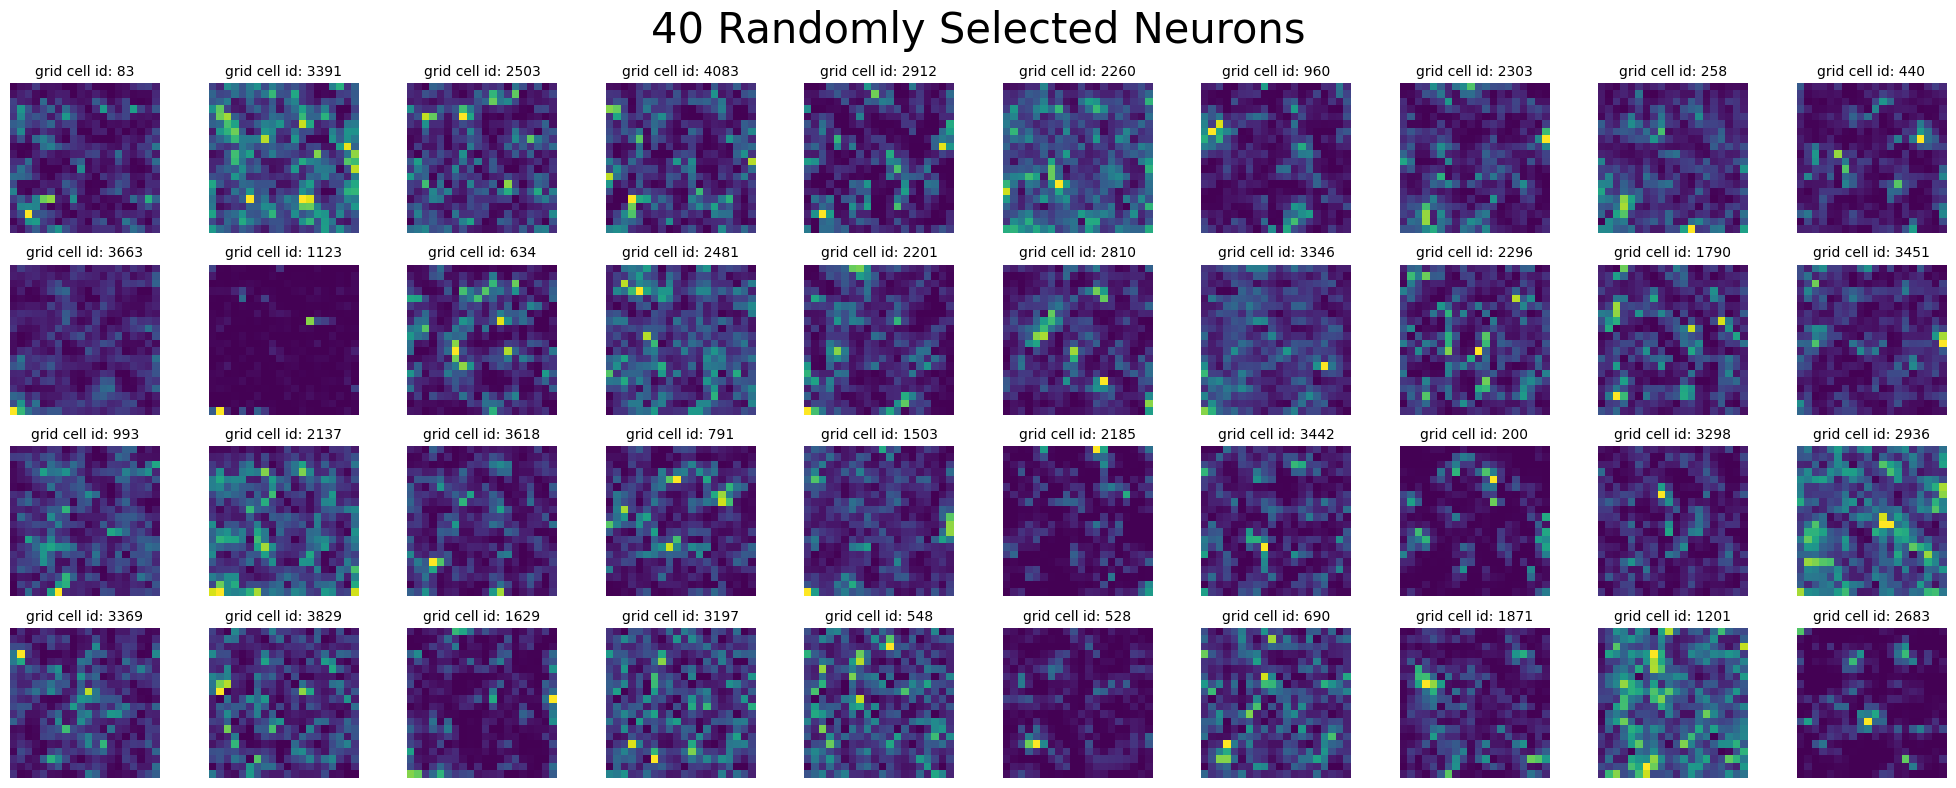

In [9]:
num_plots = 40
plot_rate_map(
    None,
    num_plots,
    dual_agent_activations[-1],
    title=f"{num_plots} Randomly Selected Neurons",
)

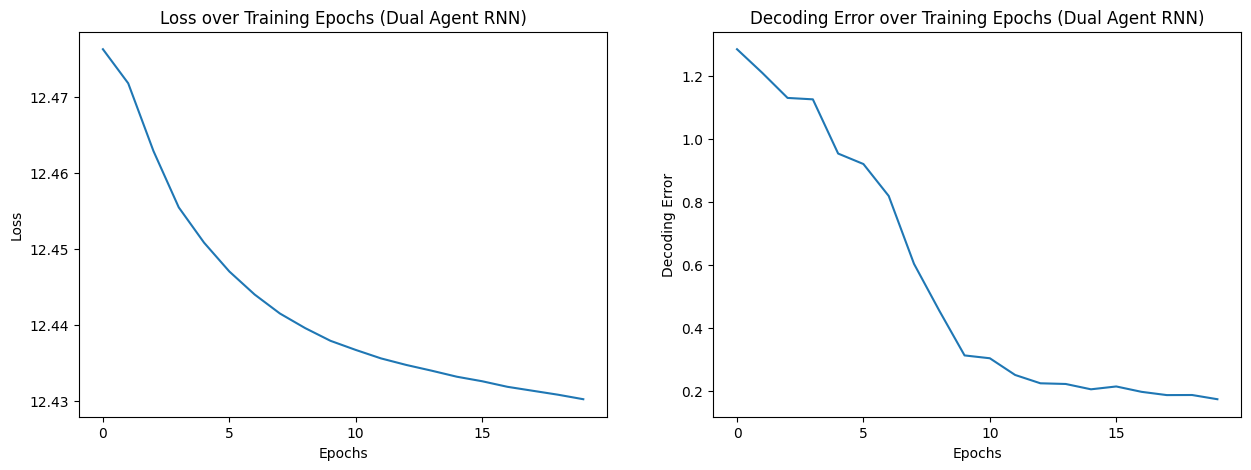

In [10]:
loss_path = os.path.join(
    parent_dir, dual_model_folder, dual_model_parameters, "loss.npy"
)
loss = np.load(loss_path)
loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)

decoding_error_path = os.path.join(
    parent_dir, dual_model_folder, dual_model_parameters, "decoding_error.npy"
)

decoding_error = np.load(decoding_error_path)
decoding_error_aggregated = np.mean(decoding_error.reshape(-1, 2), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs = list(range(0, 20))
axs[0].plot(epochs, loss_aggregated)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Training Epochs (Dual Agent RNN)")

axs[0].set_xticks(epochs[::5])

axs[1].plot(epochs, decoding_error_aggregated)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Decoding Error")
axs[1].set_title("Decoding Error over Training Epochs (Dual Agent RNN)")

axs[1].set_xticks(epochs[::5]);